In [1]:
# TODO use pytorch dists to samples and get density in order to make loss

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from vae import VAE, loss_function
from helpers.summarize import TorchSummarizeDf
from helpers.dataset import NumpyDataset, TQDMDaskProgressBar, load_npzs
from rnn import MDNRNN

In [5]:
cuda= torch.cuda.is_available()
env_name='sonic'
num_epochs=200
batch_size=64

In [6]:
# Load VAE
vae = VAE(image_size=128, z_dim=32, conv_dim=64, code_dim=16, k_dim=128)
if cuda:
    vae = vae.cuda()
# # Resume?
NAME='VAE_2xv5'
save_file = f'./models/{NAME}_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(save_file)
    vae.load_state_dict(state_dict)
    print(f'loaded {save_file}')

loaded ./models/VAE_2xv5_state_dict.pkl


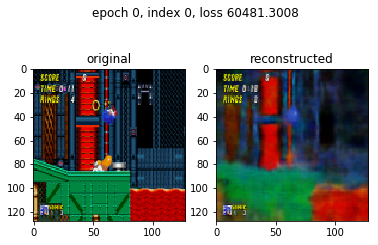

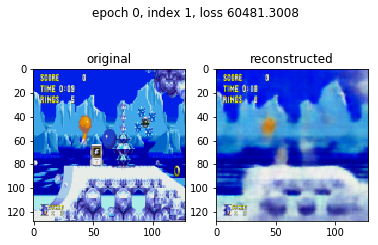

In [7]:
# Test VAE
# load
data_cache_file = '/tmp/sonic_vae2.hdf5'
data = da.from_array(h5py.File(data_cache_file, mode='r')['x'], chunks=(2000, 128, 128, 3))
data
data_split = int(len(data)*0.8)
data_train = data[:data_split]
data_test = data[data_split:]
data_train, data_test

   
dataset_train = NumpyDataset(data_train)
loader_train = torch.utils.data.DataLoader(dataset_train, pin_memory=True, shuffle=False, batch_size=batch_size)


dataset_test = NumpyDataset(data_test)
loader_test = torch.utils.data.DataLoader(dataset_test, pin_memory=True, shuffle=False, batch_size=batch_size)

dataset_train, loader_train

# Plot reconstructions
def plot_results(loader=loader_test, n=2, epoch=0):
    x, = next(iter(loader))

    X = Variable(x).cuda().transpose(1,3).contiguous()
    Y, mu, logvar = vae.forward(X)
    loss = loss_function(Y, X, mu, logvar)

    y=Y.cpu().data.transpose(1,3).numpy()
    for i in range(n):
        plt.subplot(1, 2, 1)
        plt.title('original')
        plt.imshow(x[i].numpy())

        plt.subplot(1, 2, 2)
        plt.imshow(y[i])
        plt.title('reconstructed')

        plt.suptitle('epoch {}, index {}, loss {:2.4f}'.format(epoch, i, loss.cpu().data.numpy()))
        plt.show()
        
plot_results(loader=loader_test, n=2, epoch=0)

In [8]:
# Load MDRNN
z_dim, action_dim, hidden_size, n_mixture, temp = 128, 12, 256, 5, 0.0
batch_size = 20
seq_len = 4

mdnrnn = MDNRNN(z_dim, action_dim, hidden_size, n_mixture, temp)

if cuda:
    mdnrnn = mdnrnn.cuda()

optimizer = optim.Adam(mdnrnn.parameters(), lr=1e-4)
import torch.optim.lr_scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

In [9]:
# Train

In [10]:
from custom_envs.env import make_env
current_env_name= 'sonic'
batch_size = 20

env = make_env(current_env_name)


# do a rollout
actions = []
observations = []
rewards=[]

observation = env.reset()
for i in range(batch_size):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    actions.append(action)
    observations.append(observation)
    rewards.append(reward)
    
env.close()

# stack
actions = np.stack(actions)
observations = np.stack(observations)
rewards = np.stack(rewards)
actions.shape

Importing 0 potential games...
Imported 0 games


(20, 12)

In [11]:
X = Variable(torch.from_numpy(observations)).cuda().transpose(1,3).contiguous()
Y, mu, logvar = vae.forward(X)
z = vae.sample(mu, logvar).data.cpu().numpy()
z.shape

(20, 128)

In [12]:
# take windows
# make padded sequences, we need to make the data in shape (batch, window_of_timesteps, features)

def timeseries_to_seq(x, window=3, pad=True):
    """
  Inputs:
  - x: shape (timeseries, features)
  - window: e.g. 3
  - pad: Wether to pad the input sequence or not (e.g. if you prepadded it or provided extra length)
  Outputs:
  - y: shape shape (batch, window, features)
    where batch=timeseries-window if pad=False or batch=timeseries if pad=True
    
  Usage:
  x= np.range(1000)
  x_stacked = timeseries_to_seq(x, window=50)
  m = torch.nn.LSTM()
  y =  m(x_stacked)[0]
  """
    if pad:
        x = np.pad(x, [[window, 0], [0, 0]], mode='constant')
    y = np.stack([x[i:i + window][::-1] for i in range(len(x)-window)], axis=1)
    y = np.transpose(y, (1,0,2))
    return y

actions = timeseries_to_seq(actions, window=seq_len)
z = timeseries_to_seq(z, window=seq_len)
actions.shape, z.shape

((20, 4, 12), (20, 4, 128))

In [13]:
z_v = Variable(torch.from_numpy(z)).cuda()
actions_v = Variable(torch.from_numpy(actions.astype(np.uint8))).float().cuda()
print(actions_v.shape, z_v.shape)
z_pred, hidden_state = mdnrnn.forward(z_v, actions_v)
print(z_pred.shape)


torch.Size([20, 4, 12]) torch.Size([20, 4, 128])
torch.Size([20, 4, 256])


In [14]:
# TODO this is probobly wrong! fixme by checking (can I just use torch multinomial? I compared to https://github.com/AppliedDataSciencePartners/WorldModels/blob/master/rnn/arch.py#L86 but is that right since they commented out part)
loss = mdnrnn.rnn_loss(z_v, z_pred)
loss

tensor([-3.9231, -3.8769, -3.8441, -3.8037, -3.7715, -3.7747, -3.7652,
        -3.7661, -3.7595, -3.7701, -3.7876, -3.8038, -3.8175, -3.8237,
        -3.8195, -3.8293, -3.8236, -3.8264, -3.8190, -3.8225], device='cuda:0')

In [15]:
optimizer.zero_grad()
loss.sum().backward()
optimizer.step()

# DEBUG can we replace tf_normal with torch normal?

In [16]:
pi, mu, sigma = mdnrnn.get_mixture_coef(z_pred)
z_prob1= mdnrnn.tf_normal(z_v, mu, sigma)
z_prob1.shape

AttributeError: 'MDNRNN' object has no attribute 'tf_normal'

In [ ]:
import torch.distributions
# replace tf_normal with pytorch normal dist logprob
rollout_length = z_v.size(1)
z_v2 = z_v.repeat((1,1,mdnrnn.n_mixture))
mu2 = mu.view((-1, rollout_length, mdnrnn.n_mixture, mdnrnn.z_dim))
sigma2 = sigma.view((-1, rollout_length, mdnrnn.n_mixture, mdnrnn.z_dim))
z_v2 = z_v2.view(-1, rollout_length, mdnrnn.n_mixture, mdnrnn.z_dim)
z_v2.shape, z_v.shape, mu.shape

z_normals = torch.distributions.Normal(mu2, sigma2)
z = z_normals.sample()
z_prob = z_normals.log_prob(z_v2).exp()
mu.shape, sigma.shape, z_prob.shape

In [ ]:
z_v.shape, z.shape

In [ ]:
# TODO confirm this works and the dimensions shapes are right
from torch import normal, multinomial

pi, mean, sigma = mdnrnn.get_mixture_coef(z_pred)

batch_size, seq_len, z_dim  = z_pred.size(0)
# randomly draw a mixture model

# pi = pi.contiguous().view(-1), 
# mean = mean.contiguous().view(-1), 
# sigma = sigma.contiguous().view(-1)

pi = pi.view(batch_size,-1)
mean = mean.contiguous().view(batch_size,-1)
sigma = sigma.contiguous().view(batch_size,-1)
k = multinomial(pi, 1).long() # one for each batch

# Multi d select
start = (mdnrnn.z_dim * k).squeeze()
end = (mdnrnn.z_dim * (k+1)).squeeze()
index = torch.stack([torch.arange(start[i],end[i], dtype=torch.long) for i in range(len(start))])
if cuda:
    index=index.cuda()

selected_mean = torch.stack([torch.index_select(mean[batch], index=index[batch], dim=0) for batch in range(batch_size)],0)

selected_sigma = torch.stack([torch.index_select(sigma[batch], index=index[batch], dim=0) for batch in range(batch_size)],0)
print(selected_mean.shape, selected_sigma.shape)

z = normal(selected_mean, selected_sigma)
z.shape